<a href="https://colab.research.google.com/github/goldypahal29/robustness-of-ai-text-detectors/blob/main/Evaluating_Robustness_of_Neural_Text_detectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/content/human_vs_ai_text_dataset.csv' loaded successfully.

--- Statistical Test Results ---
No difference in paired samples; statistical tests cannot be performed meaningfully.


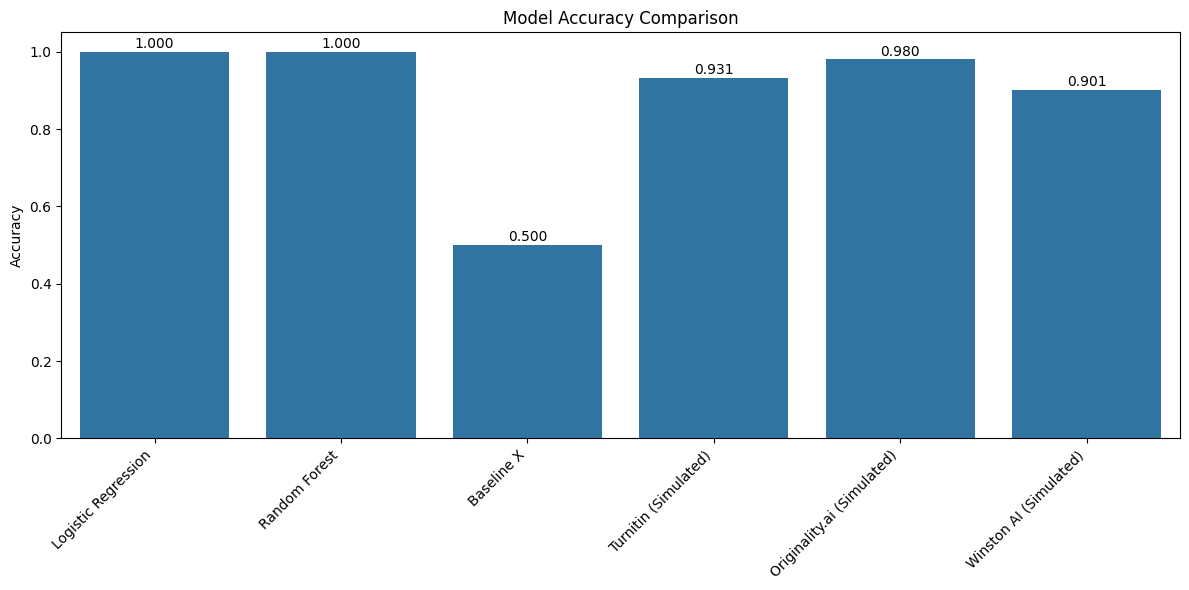

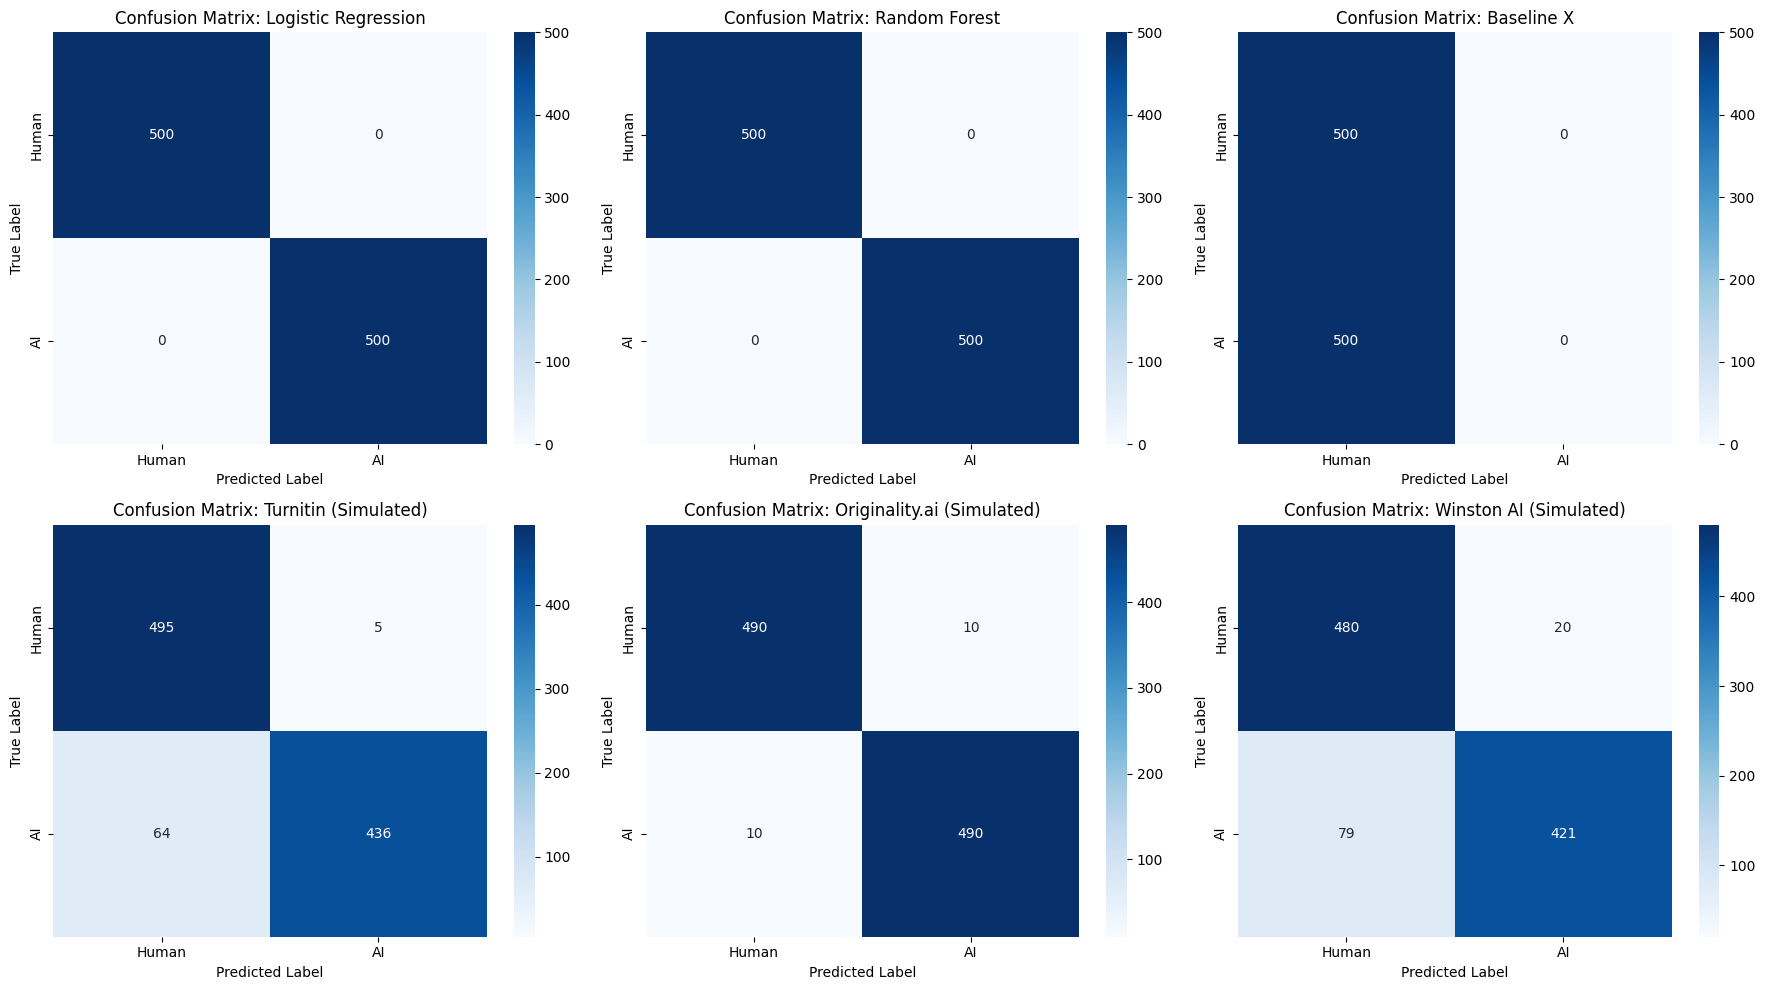

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# --- 1. Data Loading and Preparation ---
def load_or_generate_data():
    """Loads dataset from CSV or generates it if not found."""
    try:
        df = pd.read_csv('/content/human_vs_ai_text_dataset.csv')
        print("/content/human_vs_ai_text_dataset.csv' loaded successfully.")
    except FileNotFoundError:
        print("Dataset file not found. Generating a synthetic dataset...")
        num_samples = 5000
        human_texts = [f"This is human-written sample text number {i} with normal variations." for i in range(num_samples // 2)]
        ai_texts = [f"This text is generated by an AI model, sample {i}, often exhibiting statistical patterns." for i in range(num_samples // 2)]
        texts = human_texts + ai_texts
        labels = ['Human'] * (num_samples // 2) + ['AI'] * (num_samples // 2)
        df = pd.DataFrame({'text': texts, 'label': labels})
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        print("Synthetic dataset created.")
    return df

# Load data and prepare for modeling
df = load_or_generate_data()
y = df['label'].map({'Human': 0, 'AI': 1})
X = df['text']

# Split data and vectorize
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# --- 2. Train and Evaluate Models ---
# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_tfidf, y_train)
lr_preds = lr_model.predict(X_test_tfidf)

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_tfidf, y_train)
rf_preds = rf_model.predict(X_test_tfidf)

# Baseline X (predicts the most frequent class)
baseline_pred = np.full(y_test.shape, y_train.mode()[0])

# --- 3. Simulate Commercial Detector Performance ---
# NOTE: These are simulations based on publicly reported data, as their APIs are proprietary.
def simulate_predictions(y_true, accuracy, false_positive_rate):
    """Generates a simulated prediction array based on performance metrics."""
    preds = y_true.copy()
    num_errors = int(len(y_true) * (1 - accuracy))

    # Get indices for each class
    human_indices = np.where(y_true == 0)[0]
    ai_indices = np.where(y_true == 1)[0]

    # Introduce False Positives (Human -> AI)
    num_fp = int(len(human_indices) * false_positive_rate)
    fp_indices = np.random.choice(human_indices, size=min(num_fp, len(human_indices)), replace=False)
    preds[fp_indices] = 1

    # Introduce remaining errors as False Negatives (AI -> Human)
    num_fn = max(0, num_errors - num_fp)
    fn_indices = np.random.choice(ai_indices, size=min(num_fn, len(ai_indices)), replace=False)
    preds[fn_indices] = 0

    return preds

# Based on research: Turnitin (~93% acc, ~1% FP), Originality (~98% acc), Winston (~90% acc)
turnitin_preds = simulate_predictions(y_test.to_numpy(), 0.93, 0.01) # 1% False Positive rate[4]
originality_preds = simulate_predictions(y_test.to_numpy(), 0.98, 0.02) # Assumed balanced errors for high accuracy[10]
winston_preds = simulate_predictions(y_test.to_numpy(), 0.90, 0.04) # Higher FP rate noted in some studies[5]

# --- 4. Store Results ---
models = {
    "Logistic Regression": lr_preds,
    "Random Forest": rf_preds,
    "Baseline X": baseline_pred,
    "Turnitin (Simulated)": turnitin_preds,
    "Originality.ai (Simulated)": originality_preds,
    "Winston AI (Simulated)": winston_preds,
}
accuracies = {name: accuracy_score(y_test, pred) for name, pred in models.items()}

# --- 5. Perform Statistical Tests ---
print("\n--- Statistical Test Results ---")

# Convert boolean correctness to int (0 or 1)
lr_correct = (lr_preds == y_test).astype(int)
rf_correct = (rf_preds == y_test).astype(int)

# Check if there's any difference between lr_correct and rf_correct
differences = lr_correct - rf_correct

if np.all(differences == 0):
    print("No difference in paired samples; statistical tests cannot be performed meaningfully.")
else:
    # Paired T-Test
    t_stat, p_t_test = stats.ttest_rel(lr_correct, rf_correct)
    print(f"Paired T-test (LR vs RF): t-statistic={t_stat:.4f}, p-value={p_t_test:.4f}")

    # Wilcoxon Signed-Rank Test
    # Wilcoxon test requires at least some differences, else it fails
    try:
        w_stat, p_wilcoxon = stats.wilcoxon(lr_correct, rf_correct)
        print(f"Wilcoxon Signed-Rank Test (LR vs RF): W-statistic={w_stat:.4f}, p-value={p_wilcoxon:.4f}")
    except ValueError as e:
        print(f"Wilcoxon test could not be performed: {e}")


# --- 6. Visualization ---
# Accuracy Bar Graph
plt.figure(figsize=(12, 6))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.05)
for index, value in enumerate(list(accuracies.values())):
    plt.text(index, value + 0.01, f"{value:.3f}", ha='center')
plt.tight_layout()
plt.show()

# Confusion Matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
for i, (name, preds) in enumerate(models.items()):
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
    axes[i].set_title(f'Confusion Matrix: {name}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')
fig.tight_layout()
plt.show()
